This tutorial is about how to use Bayesian Convolution Neural Network (BCNN) via Vational Inference (VI) using tensorflow_probability.

In this tutorial, we will work with the cifa_10 data set. The link of the discription can be found here: [https://keras.io/api/datasets/cifar10/](https://keras.io/api/datasets/cifar10/). We can load the data from keras like below or download the data from [here](https://www.cs.toronto.edu/~kriz/cifar.html). 

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories (10 numbers from 0 to 9 associate with 10 catergories from airplane to truck ).

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False
    
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.5.0  running in colab?:  True


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

# Load + explore + prepare the data

## Load and explore the data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train.shape: ", x_train.shape, "\n")
print("y_train.shape", y_train.shape, "\n")
print("x_test.shape", x_test.shape, "\n")
print("y_test.shape", y_test.shape, "\n")
print("First element of x_train: ", x_train[1][1], "\n")
print("First element of y_train: ", y_train[1], "\n")

170500096/170498071 [==============================] - 4s 0us/step
x_train.shape:  (50000, 32, 32, 3) 

y_train.shape (50000, 1) 

x_test.shape (10000, 32, 32, 3) 

y_test.shape (10000, 1) 

First element of x_train:  [[140 160 169]
 [145 153 154]
 [125 125 118]
 [124 129 132]
 [150 161 173]
 [152 164 175]
 [174 188 200]
 [178 189 196]
 [134 139 137]
 [110 111 102]
 [133 127 120]
 [163 156 156]
 [192 192 187]
 [218 219 215]
 [240 241 238]
 [245 246 245]
 [241 242 239]
 [238 239 235]
 [234 235 229]
 [226 227 220]
 [142 143 136]
 [ 96  97  85]
 [ 99 101  84]
 [ 95  96  87]
 [ 89  89  86]
 [ 80  81  77]
 [ 65  67  60]
 [ 84  86  76]
 [ 92  95  80]
 [ 96  99  78]
 [ 77  80  62]
 [ 71  73  61]] 

First element of y_train:  [9] 



From the shape of the x_train, (50000, 32, 32, 3), 
- The first number 50000 represent the total number of pictures in the set. 
- The next two number (32, 32) represent that each image is a 32×32 pixels one. 
- The last number is 3, it represents three color channels (Red, Green, Blue)

- Look at the first element of x_train confirm that pixel values range from 0 to 255. This is a picture with y=9, a truck.

In [4]:
# disable the tensorflow eager mode.
# To avoid getting errors for the VI NN and to turn on and off the dropout in the MC dropout NN.
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

Let's plot a random example of each class in the training set. 

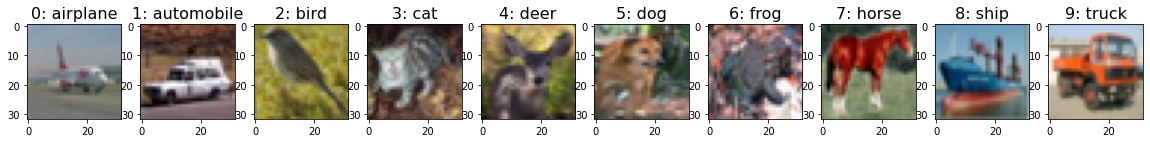

In [5]:
# Set the labels associate with 10 classes 
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
# The below code will take i in set of unique values of y_train with is {0,..,9}
# then randomly choose 1 index where y=i and draw picture having that index  
np.random.seed(46786)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)

## Preapre the data

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
print(y_train[0:3])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In the below step, we combind the x-data and y-data to create train and test set, then we take 100 images from the test set to create validation set. So now we have 50000 images on the train set, 100 images on the valiadation set, and 10,000-100 images on the test set. Note that in this step, we also scale the pixels down to 0-1 range by devising them to 255.

In [8]:
x_train = x_train/255
x_test  = x_test/255
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = test_ds.take(100)

### Some notes about the data generated by tf.data.Dataset.from_tensor_slices


We can see the component of each line of the train data by the below command (the same things can be done with val_ds and test_ds). From this we see that each line cotains two parts: first part contains infomation to create an image, the second part contain infomation of the classes that image belong/not belong to. 

In [9]:
# the component of each line of the train_ds
print("component of each line of the train data: \n", train_ds.element_spec)

component of each line of the train data: 
 (TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))


Even though we already combined the x_train and y_train to create a Tensor-Slice-Dataset train_ds. We can still directly get access to x_train and y_train using the code below. Similarly for val_ds and test_ds

In [10]:
# tf.enable_eager_execution()
x = [x for x, y in train_ds]
y = [y for x, y in train_ds]
# print("First image in the train set", x[1])    #uncomment to se the first image
print("First catergorical in the train set", y[1])

First catergorical in the train set tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


In [11]:
z= np.concatenate([z for z in val_ds], axis=0)
z[1]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [12]:
test_ds.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

## Preprocessing the data

In [13]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(x_train)


# A BCNN model via Variational Inference (VI)

## Create a model+ fit the model to the train_ds + predict the model on the test_ds

*Variational inference* learns a *variational distribution* $q_{\phi}(\theta)$, parameterized by a set of parameters $\phi$, to approximate the Bayesian posterior $p(\theta | D)$. The values of the parameters $\phi$ is inferred such that the variational distribution is as close as possible to the Bayesian posterior.

kl_divergence(q, p) support the vational inference, represents for [Kullback_leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), measures the how variational distribution $q$ is different from posterior $p$

In tensorflow_probability, Convolution2DFlipout and DenseFlipout are used in stead of Convolution2D and Dense as in CNN. 

In [15]:
image_size = (32,32,3)
train_len = len(x_train)
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / train_len

model_vi = tf.keras.Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))

model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))

model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(10, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [16]:
epochs = 100
# from keras import backend as K
# K.set_value(model_vi.optimizer.learning_rate, 0.005)
model_vi_hist = model_vi.fit(train_dataset,epochs = epochs,batch_size=32, 
                             validation_data = val_dataset)
# model_vi.save('BCNN_cf10.h5') 

Epoch 1/100
782/782 [==============================] - 46s 17ms/step - loss: 7.3930 - accuracy: 0.2585 - val_loss: 6.5670 - val_accuracy: 0.4700
Epoch 2/100
782/782 [==============================] - 14s 17ms/step - loss: 6.2045 - accuracy: 0.3986 - val_loss: 5.7329 - val_accuracy: 0.4800
Epoch 3/100
782/782 [==============================] - 12s 16ms/step - loss: 5.4943 - accuracy: 0.4447 - val_loss: 5.1777 - val_accuracy: 0.4700
Epoch 4/100
782/782 [==============================] - 12s 16ms/step - loss: 4.9725 - accuracy: 0.4762 - val_loss: 4.7286 - val_accuracy: 0.4900
Epoch 5/100
782/782 [==============================] - 14s 17ms/step - loss: 4.5918 - accuracy: 0.4998 - val_loss: 4.4142 - val_accuracy: 0.5100
Epoch 6/100
782/782 [==============================] - 14s 17ms/step - loss: 4.2982 - accuracy: 0.5200 - val_loss: 4.0903 - val_accuracy: 0.6100
Epoch 7/100
782/782 [==============================] - 13s 16ms/step - loss: 4.0776 - accuracy: 0.5328 - val_loss: 3.9366 - val_ac

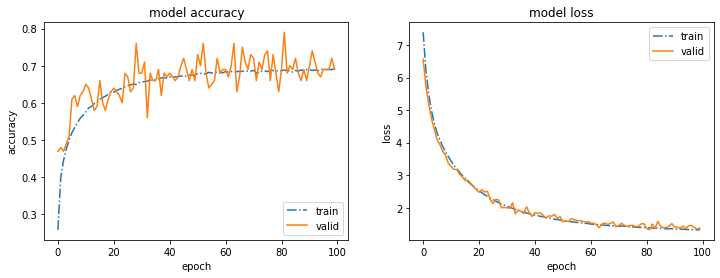

In [17]:
def draw_hist_f(history):
    """hist: a history learning curve created by a model.fit where model is a CNN model"""
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,(1))
    plt.plot(history.history['accuracy'],linestyle='-.')
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='lower right')
    plt.subplot(1,2,(2))
    plt.plot(history.history['loss'],linestyle='-.')
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    
# call the function to plot the training and validation accuracy and loss
draw_hist_f(model_vi_hist)

In [18]:

labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

T=50 #we predict the same each image for T times and calculate the mean predicted probability
pred_vi=np.zeros((len(x_test),10))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(T,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)   #mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))  #mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14))   #Numerical Stability
    
pred_labels_vi=np.array([labels[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)   #negative loglikelihood

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [19]:
true_labels = np.array([labels[np.argmax(y_test[i])] for i in range(0,len(y_test))])
test_acc_all_vi = np.average(true_labels==pred_labels_vi)
test_acc_all_vi

0.6958

## The uncertainty of the BCNN

In [20]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[range(0,len(x_test))],bins=30, density=True,alpha = 0.7)
    # plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    # plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

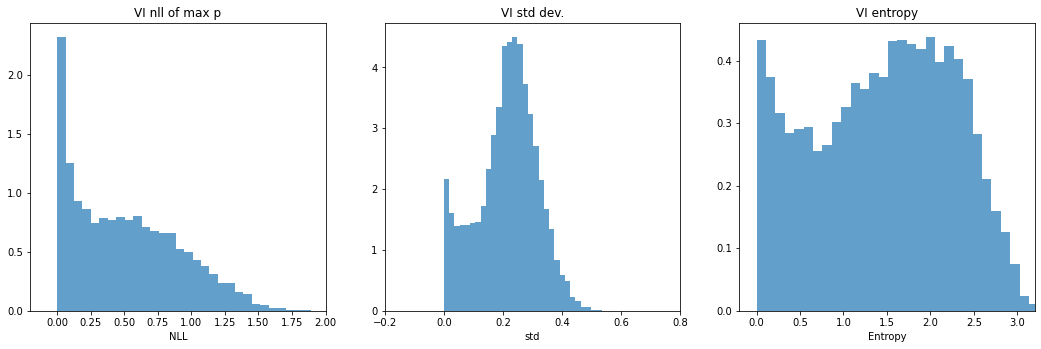

In [21]:
plt.figure(figsize=(18,18))
plt.subplot(3,3,4)
plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,5)
plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
plt.subplot(3,3,6)
plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

## Check the result of an image in the test_ds

So now we want to check the result of an image in the test set. 
The below function will predict the $i^{th}$ image in the set using BCNN via VI and compare the result with the true image and label.

In [22]:
# multi_img=np.tile(x_test[0],(1,1,1,1))

# Take the features of the i_th image 
def check_vi_f(i): 
  test_in = x_test[i]
  test_in.shape = (1,) + x_test[i].shape 
  print("Check the shape of the image: ", test_in.shape)
  preds_img = model_vi.predict(test_in)

  # Now, we want to to plot the prediction of the model with this image
  plt.figure(figsize=(12,5))
  # plt.text(1.1,1.1, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
  plt.subplot(1,2,1)
  for j in range(0,50):
    plt.scatter(range(0,10),model_vi.predict(test_in),c="blue",alpha=0.2)
  plt.title('predition by BCNN via VI')
  plt.xticks(range(0,10),labels=labels,fontsize=16)
  plt.xticks(rotation=90)
  plt.ylim([0,1])
  plt.ylabel("P(class)",fontsize=16)

  plt.subplot(1,2,2)
  print(plt.imshow(x_test[i]))
  plt.title('The image')

  # Check the true label of the image
  print("The true label of the image is: ", labels[np.nonzero(y_test[i].tolist())[0][0]])


Check the shape of the image:  (1, 32, 32, 3)
AxesImage(473.236,45;304.364x271.8)
The true label of the image is:  horse


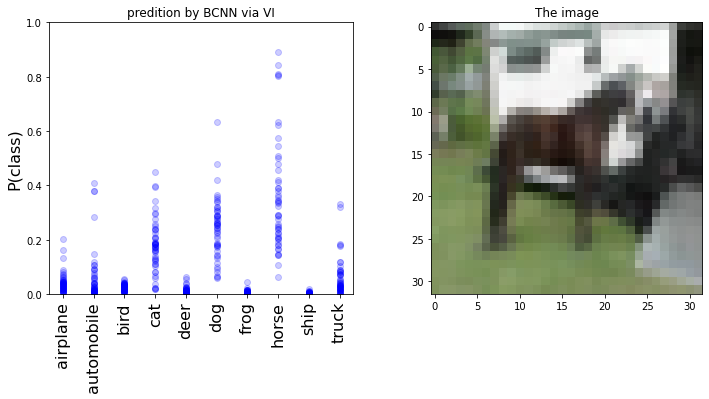

In [23]:
check_vi_f(20)

As you can see, when I try with the 20th image in the test set, the picture was predicted as a horse which is the same as the true label of the picture. However, we see more detail of the uncertain levels of the Bayesian prediction. There are some uncertainty that it may also be  a dog, frog, ship, truck, airplane, automobile, bird, or deer. However, the probability to be horse is significantly higher than others.

## Reference: 

[Probabilistics Deep Learning with Python](https://tensorchiefs.github.io/dl_book/)